<a href="https://colab.research.google.com/github/SimeonHristov99/AI_Traffic_Sign_Classifier_Tensorflow/blob/main/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

## Traffic Sign Classifier

### The goal of this project is to build and train a traffic sign classifier. Results were generated in the context of the second  stage  of  the [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) dataset. The classifier is a convolutional neural network and is implemented using the deep learning framework [Keras](https://keras.io/) from the [TensorFlow](https://www.tensorflow.org/) library.

### Inspired by:
- [CNN Design for Real-Time Traffic Sign Recognition](https://www.sciencedirect.com/science/article/pii/S1877705817341231)
- [Man vs. computer: benchmarking machine learning algorithms for traffic sign recognition](https://christian-igel.github.io/paper/MvCBMLAfTSR.pdf)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix

# Loading data

In [2]:
# # Run one time only. Requires Kaggle API access key to download the dataset.
if os.path.isdir('data') == False:
  !pip install -q kaggle

  from google.colab import drive

  drive.mount('/gdrive')

  assert os.getcwd() == '/content'

  os.environ['KAGGLE_CONFIG_DIR'] = '../gdrive/MyDrive/kaggle'

  !kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p /content/data/ --unzip

In [3]:
traindf = pd.read_csv('/content/data/Train.csv',dtype=str)
testdf = pd.read_csv('/content/data/Test.csv',dtype=str)

In [4]:
BATCH_SIZE = 50
IM_SIZE = 28
CLASSES = 43
TRAIN_DATA_DIR = '/content/data'
TEST_DATA_DIR = '/content/data'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.05, # set validation split tf.image.rgb_to_grayscale,
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    batch_size=BATCH_SIZE,
    subset='training', # set as training data
    target_size=(IM_SIZE, IM_SIZE)
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    batch_size=BATCH_SIZE,
    subset='validation', # set as training data
    target_size=(IM_SIZE, IM_SIZE)
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory=TEST_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=12630,
    shuffle=False,
)

print(f'{len(train_generator)} training batches. Each with {train_generator[0][0].shape[0]} images.')
print(f'{len(val_generator)} validation batches. Each with {val_generator[0][0].shape[0]} images.')
print(f'{len(test_generator)} test batches. Each with {test_generator[0][0].shape[0]} images.')

Found 37249 validated image filenames belonging to 43 classes.
Found 1960 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.
745 training batches. Each with 50 images.
40 validation batches. Each with 50 images.
1 test batches. Each with 12630 images.


# Visualizing data

In [5]:
X_train_batch, y_train_batch = next(train_generator)
X_val_batch, y_val_batch = next(val_generator)

print(type(X_train_batch), X_train_batch.shape, type(y_train_batch), y_train_batch.shape)
print(type(X_val_batch), X_val_batch.shape, type(y_val_batch), y_val_batch.shape)

<class 'numpy.ndarray'> (50, 28, 28, 3) <class 'numpy.ndarray'> (50, 43)
<class 'numpy.ndarray'> (50, 28, 28, 3) <class 'numpy.ndarray'> (50, 43)


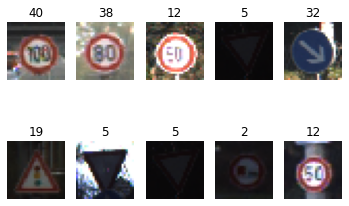

In [6]:
for i in range(10):
  plt.subplot(2, 5, i + 1)

  rand_idx = np.random.randint(X_train_batch.shape[0])
  image = X_train_batch[rand_idx]
  
  plt.imshow(image)
  plt.axis('off')
  plt.title(np.argmax(y_train_batch[rand_idx]))

plt.show()

# Choosing a model

In [7]:
input_shape = X_train_batch[0].shape

model = keras.models.Sequential([ # modified lenet_5
    keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
    keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.85),
    keras.layers.Dense(CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        6416      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        6416      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

# Training

In [8]:
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = val_generator.samples // BATCH_SIZE,
    epochs = 15
)

Epoch 1/15
744/744 [==============================] - 23s 21ms/step - loss: 4.1676 - accuracy: 0.0963 - val_loss: 4.7081 - val_accuracy: 0.0000e+00
Epoch 2/15
744/744 [==============================] - 15s 20ms/step - loss: 3.1664 - accuracy: 0.1665 - val_loss: 4.8670 - val_accuracy: 0.0000e+00
Epoch 3/15
744/744 [==============================] - 15s 20ms/step - loss: 1.8519 - accuracy: 0.4678 - val_loss: 4.3695 - val_accuracy: 0.1262
Epoch 4/15
744/744 [==============================] - 15s 20ms/step - loss: 1.0845 - accuracy: 0.6728 - val_loss: 4.5297 - val_accuracy: 0.1579
Epoch 5/15
744/744 [==============================] - 15s 20ms/step - loss: 0.7112 - accuracy: 0.7812 - val_loss: 4.3504 - val_accuracy: 0.3344
Epoch 6/15
744/744 [==============================] - 15s 20ms/step - loss: 0.5433 - accuracy: 0.8343 - val_loss: 4.8794 - val_accuracy: 0.3333
Epoch 7/15
744/744 [==============================] - 15s 20ms/step - loss: 0.4290 - accuracy: 0.8692 - val_loss: 4.2607 - val_a

# Evaluation

In [9]:
#Predicting the classes of images
test_generator.reset()
predictions = model.predict(test_generator)
print('predictions shape:', predictions.shape)

# getting the labels
pred_labels = list(np.argmax(predictions, axis=1))
predicted_class_indices=np.argmax(predictions,axis=1)

# getting true labels
true_labels = test_generator.classes

predictions shape: (12630, 43)


In [10]:
# Plot the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
cm

array([[  0,  31,   0, ...,   0,   4,   0],
       [  0, 633,   0, ...,   0,   0,   0],
       [  0,   0, 651, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 403,  29,   0],
       [  0,   0,   0, ...,   1, 444,   1],
       [  0,   0,   3, ...,   0,   0, 477]])

Text(0.5, 1.0, 'Loss curves')

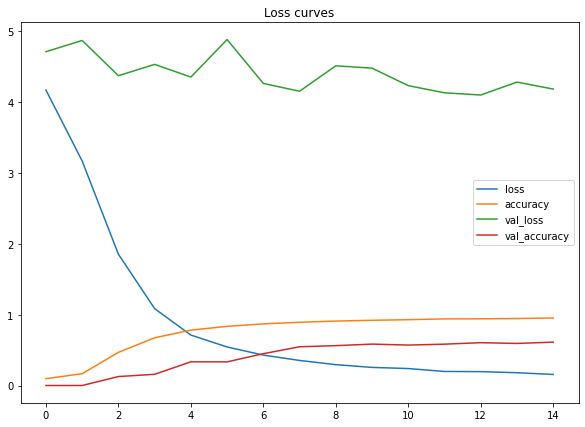

In [11]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.title('Loss curves')

In [12]:
model.evaluate(test_generator)

1/1 [==============================] - 3s 3s/step - loss: 0.3528 - accuracy: 0.9374


[0.3527582585811615, 0.9373713135719299]

# Finding the best learning rate

In [13]:
input_shape = X_train_batch[0].shape

model = keras.models.Sequential([
    keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
    keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.85),
    keras.layers.Dense(CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        1216      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        6416      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        6416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)       

In [14]:
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = val_generator.samples // BATCH_SIZE,
    epochs = 15,
    callbacks=[lr_scheduler]
)

Epoch 1/15
744/744 [==============================] - 16s 21ms/step - loss: 7.1010 - accuracy: 0.0463 - val_loss: 4.3561 - val_accuracy: 0.0000e+00
Epoch 2/15
744/744 [==============================] - 15s 20ms/step - loss: 3.7200 - accuracy: 0.0537 - val_loss: 4.1503 - val_accuracy: 0.0000e+00
Epoch 3/15
744/744 [==============================] - 15s 20ms/step - loss: 3.5189 - accuracy: 0.0564 - val_loss: 4.4007 - val_accuracy: 0.0000e+00
Epoch 4/15
744/744 [==============================] - 15s 20ms/step - loss: 3.4243 - accuracy: 0.0763 - val_loss: 4.7023 - val_accuracy: 0.0000e+00
Epoch 5/15
744/744 [==============================] - 15s 20ms/step - loss: 2.9561 - accuracy: 0.2126 - val_loss: 4.8976 - val_accuracy: 0.0000e+00
Epoch 6/15
744/744 [==============================] - 15s 20ms/step - loss: 2.1838 - accuracy: 0.3548 - val_loss: 4.3185 - val_accuracy: 0.0426
Epoch 7/15
744/744 [==============================] - 15s 20ms/step - loss: 1.7576 - accuracy: 0.4510 - val_loss: 4.

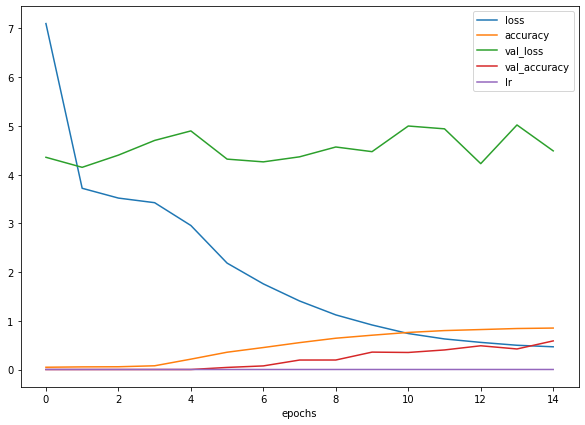

In [15]:
pd.DataFrame(history.history).plot(figsize=(10, 7), xlabel='epochs')

Text(0.5, 1.0, 'Learning Rate vs. Validation Loss')

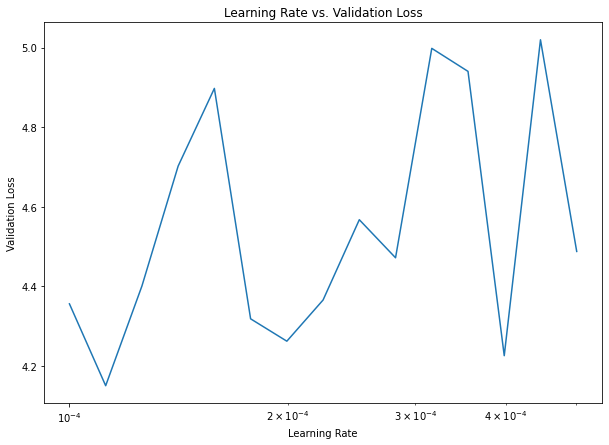

In [16]:
# Plot the learning rate vs. the loss
lrs = 1e-4 * 10**(tf.range(15)/20)
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["val_loss"])
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Learning Rate vs. Validation Loss')

In [21]:
print(3.7*1e-4)

0.00037000000000000005


# Try out a new learning rate

In [24]:
input_shape = X_train_batch[0].shape

model = keras.models.Sequential([ # modified lenet_5
    keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
    keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.85),
    keras.layers.Dense(CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3.7*1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 16)        1216      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 16)        6416      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 16)        6416      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 32)       

In [25]:
train_generator.reset()
val_generator.reset()
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = val_generator.samples // BATCH_SIZE,
    epochs = 15,
)

Epoch 1/15
744/744 [==============================] - 16s 21ms/step - loss: 5.0708 - accuracy: 0.0785 - val_loss: 4.1369 - val_accuracy: 0.0000e+00
Epoch 2/15
744/744 [==============================] - 15s 20ms/step - loss: 3.1059 - accuracy: 0.2327 - val_loss: 4.0000 - val_accuracy: 5.1282e-04
Epoch 3/15
744/744 [==============================] - 15s 20ms/step - loss: 1.6229 - accuracy: 0.5357 - val_loss: 3.6081 - val_accuracy: 0.3523
Epoch 4/15
744/744 [==============================] - 15s 20ms/step - loss: 0.8885 - accuracy: 0.7295 - val_loss: 3.8916 - val_accuracy: 0.4036
Epoch 5/15
744/744 [==============================] - 16s 21ms/step - loss: 0.5944 - accuracy: 0.8178 - val_loss: 4.2527 - val_accuracy: 0.3841
Epoch 6/15
744/744 [==============================] - 16s 21ms/step - loss: 0.4375 - accuracy: 0.8648 - val_loss: 4.0030 - val_accuracy: 0.4779
Epoch 7/15
744/744 [==============================] - 15s 21ms/step - loss: 0.3481 - accuracy: 0.8912 - val_loss: 4.0524 - val_a

Text(0.5, 1.0, 'Loss curves')

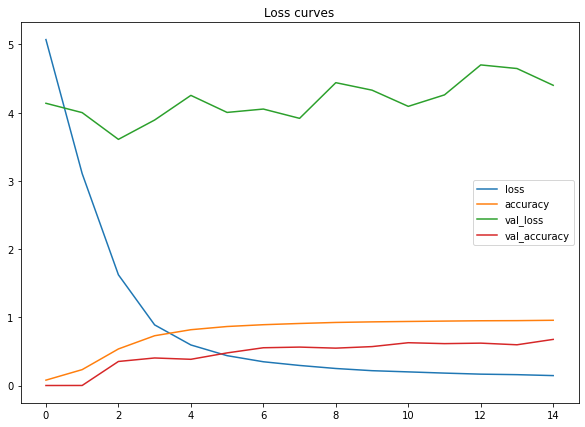

In [26]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.title('Loss curves')

In [27]:
test_generator.reset()
model.evaluate(test_generator)

1/1 [==============================] - 3s 3s/step - loss: 0.3970 - accuracy: 0.9364


[0.39700815081596375, 0.9364212155342102]